## Solving the Dice Blackjack with Q-learing agent

**Prepared by:** Makar Korchagin, Ilya Zherebtsov, Rinat Prochii, Aibek Akhmetkazy and Mukhail Gubanov

In [1]:
import gymnasium as gym
import numpy as np

from src.agent import QLearningAgent
from src.env import DiceBlackJack
from src.visualization import (
    clean_q_table,
    plot_tables_heatmaps_18,
    show_training_stats,
)


You may unveil the training process by redirecting the logs to the file and analyse then later.

In [2]:
import logging

logging.basicConfig(
    level=logging.WARNING,
    filemode="w",
    filename="training.log",
    format="[%(levelname)s] %(message)s",
)
logging.logProcesses = False

In [3]:
learning_rate = 0.10
n_episodes = 200_000
decay = lambda x: max(1 - np.sqrt(1.45 * x), 0.01)

env = DiceBlackJack()
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = QLearningAgent(env=env, n_episodes=n_episodes, seed=0x42)

### Training
Using the qrpper from gymnasium library, we can train the model and plot the training in two lines.

In [4]:
training_error = agent.train(learning_rate=learning_rate, epsilon_decay=decay)

Training: 100%|██████████| 200000/200000 [01:32<00:00, 2153.03it/s]


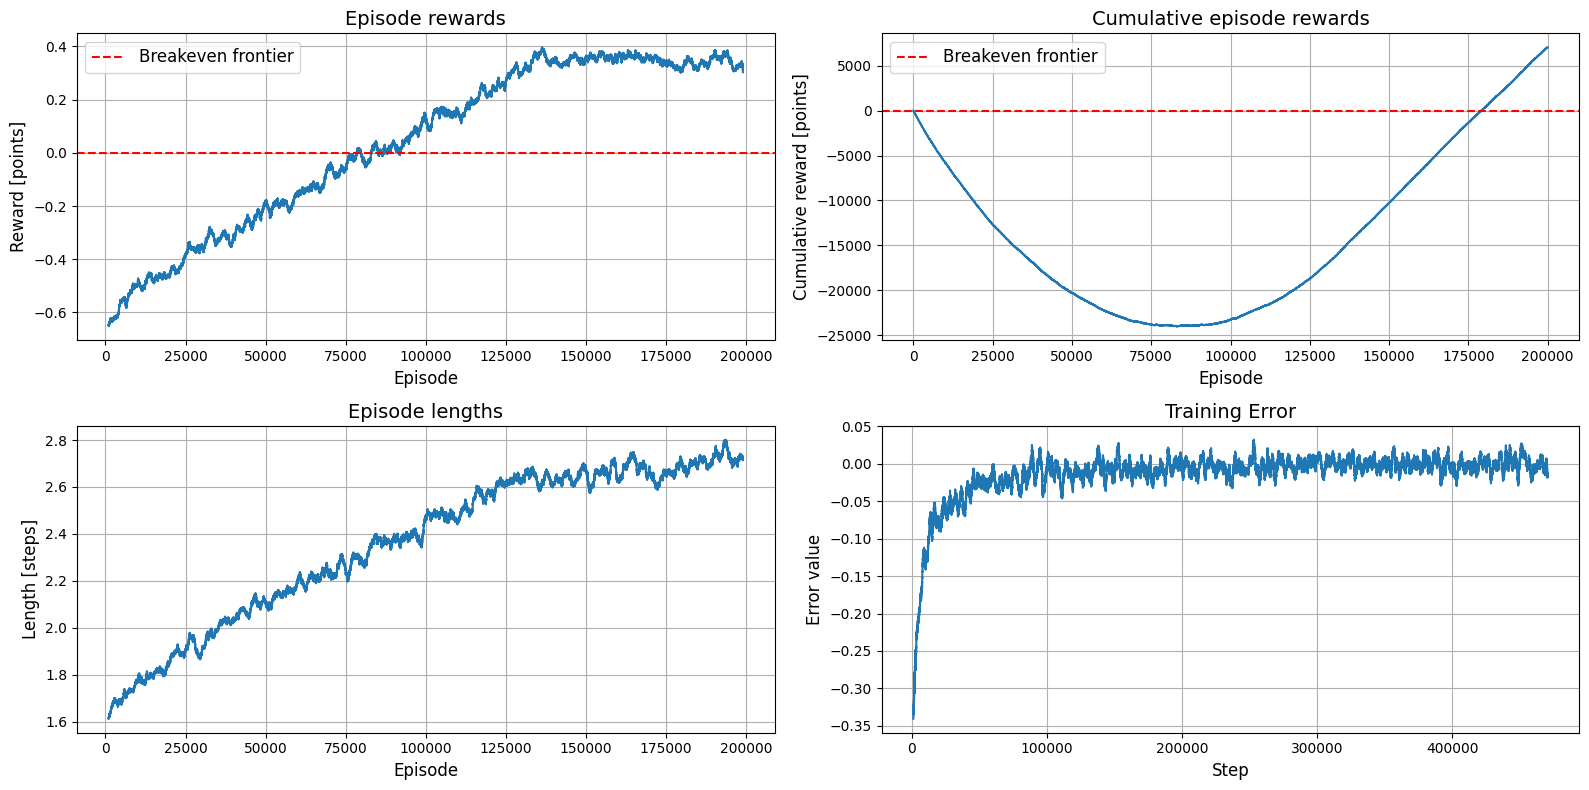

In [5]:
rolling_length = 2000
show_training_stats(env, training_error, rolling_length)

### Q-table representation
By converting the Q-table to the strategies tables, we reveal the agent's logic, that it has obtained during the training.

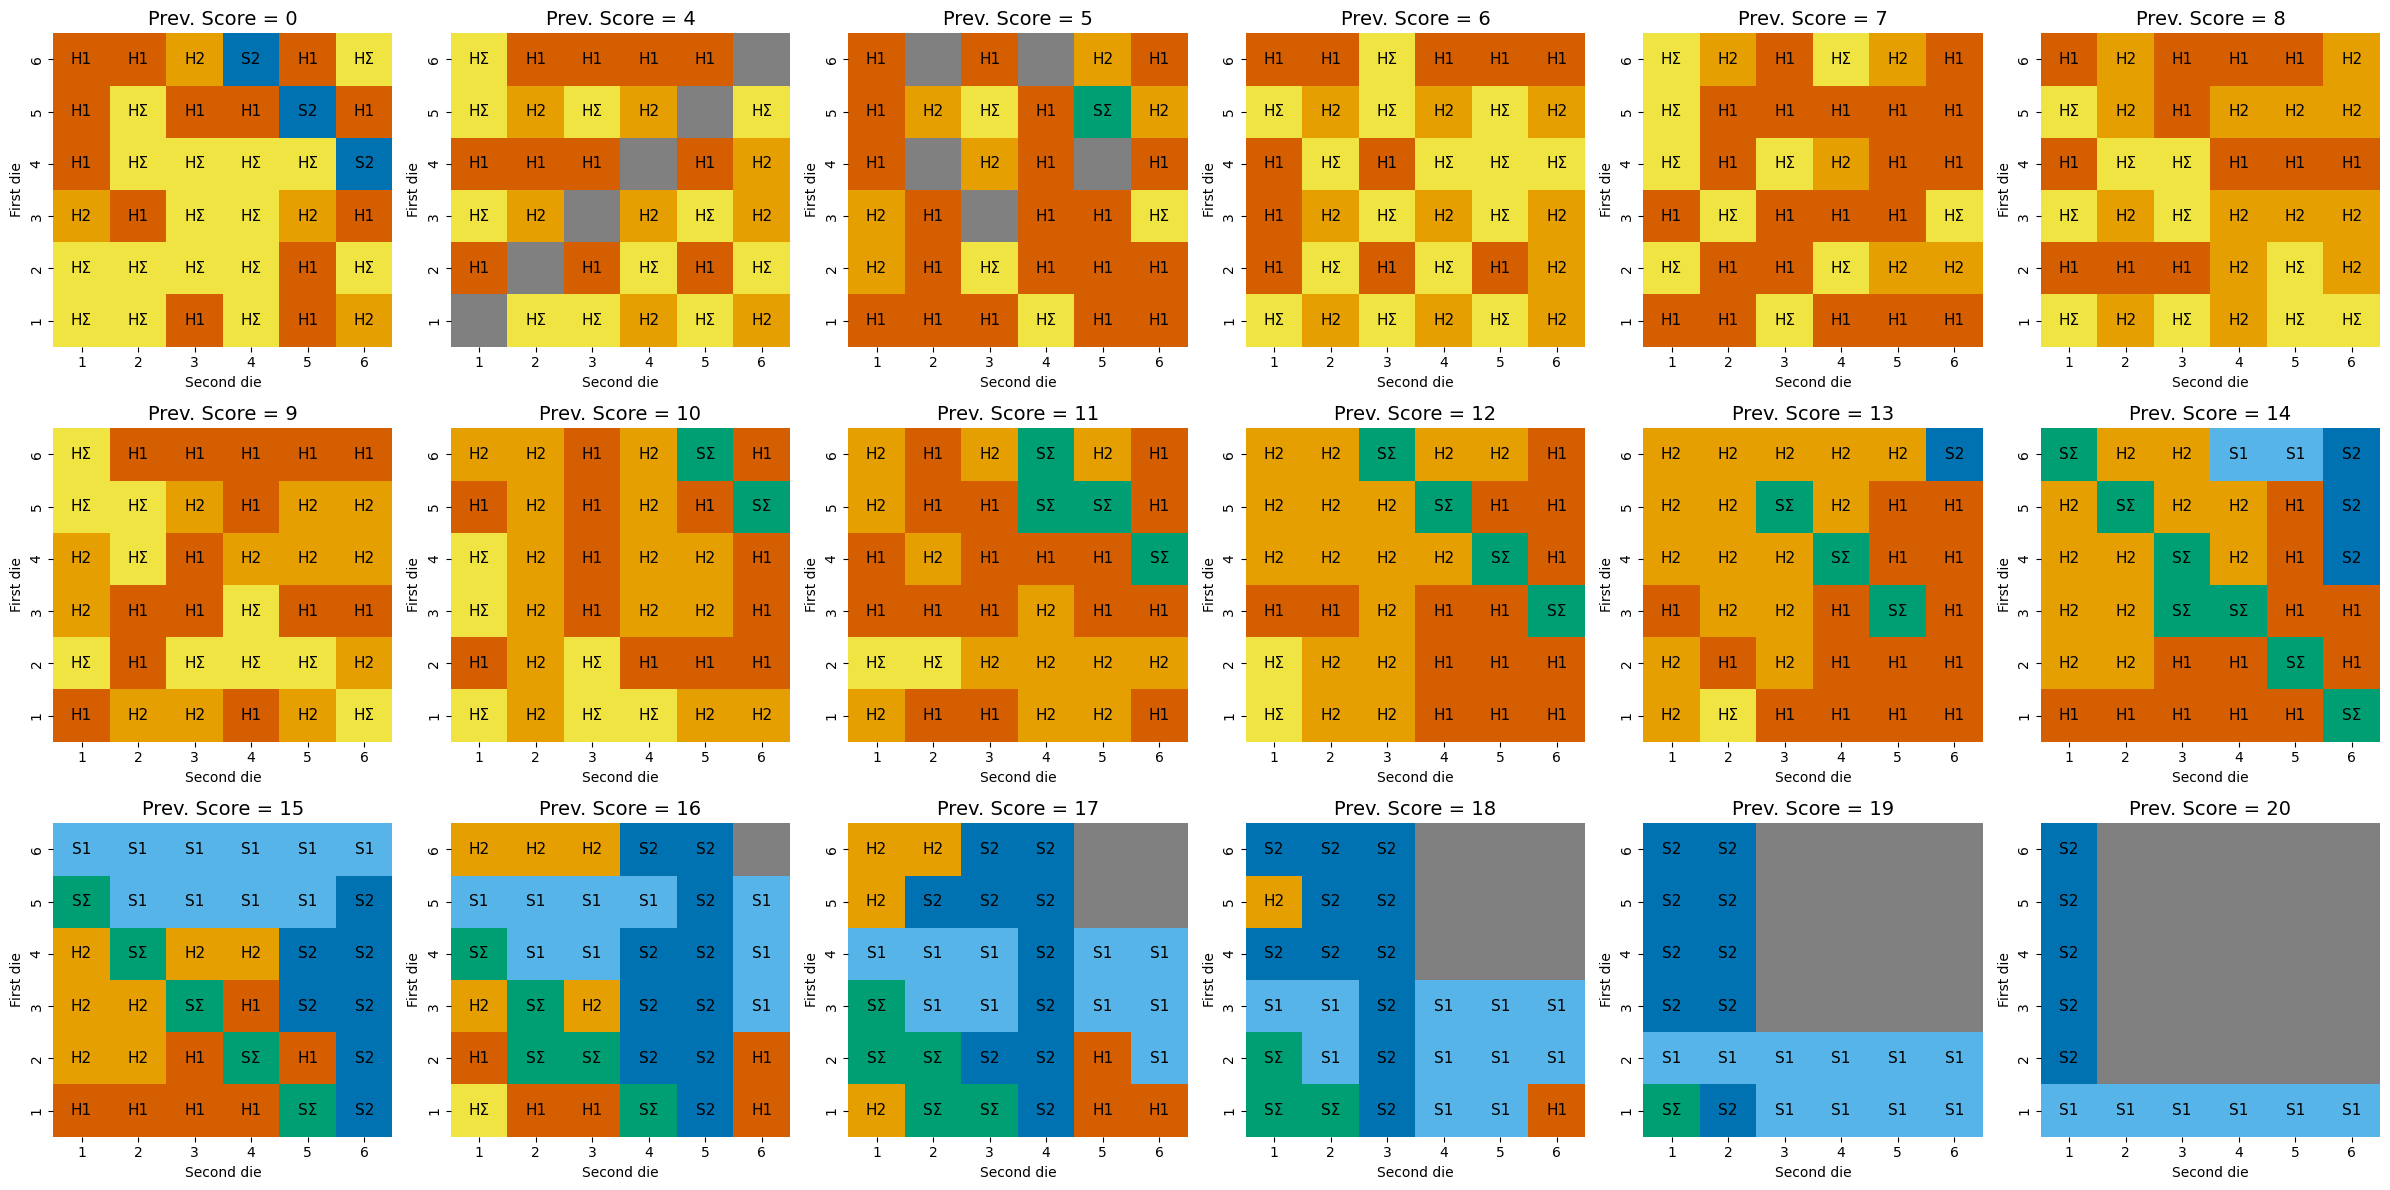

In [6]:
action_info = {
    0: ("H1", "#D55E00"),
    1: ("H2", "#E69F00"),
    2: ("HΣ", "#F0E442"),
    3: ("S1", "#56B4E9"),
    4: ("S2", "#0072B2"),
    5: ("SΣ", "#009E73"),
}

action_table = clean_q_table(agent.get_q_table())
plot_tables_heatmaps_18(action_table, action_info)